In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fonctions d’activation
def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)  
    assert result.shape == x.shape, "ReLU output must have the same shape as input"
    assert np.issubdtype(result.dtype, np.floating), "ReLU output must be a floating-point array"
    # Vérification que la sortie de ReLU est non négative

    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(np.float32)  # TODO
    assert result.shape == x.shape, "ReLU derivative output must have the same shape as input"
    assert np.issubdtype(result.dtype, np.floating), "ReLU derivative output must be a floating-point array"
    # Vérification que la sortie de la dérivée de ReLU est 0 ou 1   
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """
    Softmax activation: exp(x) / sum(exp(x))
    """
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # TODO: for numerical stability
    assert exp_x.shape == x.shape, "Softmax input and output must have the same shape"
    assert np.issubdtype(exp_x.dtype, np.floating), "Softmax output must be a floating-point array"
    # Vérification que la sortie de softmax est dans [0, 1] et que la somme par ligne est 1
    assert np.all(exp_x >= 0), "Softmax output must be non-negative"
    assert np.all(np.isfinite(exp_x)), "Softmax output must be finite"
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0, 1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result

In [3]:
# Classe MultiClassNeuralNetwork
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        """
        Initialize the neural network with given layer sizes and learning rate.
        layer_sizes: List of integers [input_size, hidden1_size, ..., output_size]
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]  # TODO 
            assert isinstance(z, np.ndarray), "Z must be a numpy array"
            assert z.ndim == 2, "Z must be a 2D array"
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{i+1} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]  # TODO
        assert isinstance(z, np.ndarray), "Z must be a numpy array"
        assert z.ndim == 2, "Z must be a 2D array"
        assert z.shape[0] == X.shape[0], f"Z first dimension ({z.shape[0]}) must match input samples ({X.shape[0]})"
        assert z.shape[1] == self.layer_sizes[-1], f"Z second dimension ({z.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        # Vérification que la sortie de Z est un tableau de nombres réels
        assert np.issubdtype(z.dtype, np.floating), "Z must be a floating-point array"
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), f"Z^{len(self.weights)} has incorrect shape"
        self.z_values.append(z)
        # Vérification de la forme de Z pour la couche de sortie
        assert isinstance(z, np.ndarray), "Z must be a numpy array"
        assert z.ndim == 2, "Z must be a 2D array"
        assert z.shape[0] == X.shape[0], f"Z first dimension ({z.shape[0]}) must match input samples ({X.shape[0]})"
        assert z.shape[1] == self.layer_sizes[-1], f"Z second dimension ({z.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        # Vérification que la sortie de Z est un tableau de nombres réels
        assert np.issubdtype(z.dtype, np.floating), "Z must be a floating-point array"
        # Vérification que la sortie de Z ne contient pas de NaN ou d'infini
        assert np.all(np.isfinite(z)), "Z must not contain NaN or infinite values"
        # Vérification que la sortie de Z est un tableau de nombres réels
        assert np.all(np.isreal(z)), "Z must contain real numbers only"
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = softmax(z)  # TODO softmax call
        assert isinstance(output, np.ndarray), "Output A must be a numpy array"
        assert output.ndim == 2, "Output A must be a 2D array"
        assert output.shape[0] == X.shape[0], f"Output A first dimension ({output.shape[0]}) must match input samples ({X.shape[0]})"
        assert output.shape[1] == self.layer_sizes[-1], f"Output A second dimension ({output.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Categorical Cross-Entropy: J = -1/m * sum(y_true * log(y_pred))
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))  # TODO
        assert isinstance(loss, float), "Loss must be a float"
        assert loss >= 0, "Loss must be non-negative"
        # Vérification que la perte n'est pas NaN
        assert np.isfinite(loss), "Loss must be finite"
        assert not np.isinf(loss), "Loss must not be infinite"
        # Vérification que la perte n'est pas NaN
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred, axis=1)  # TODO
        assert predictions.ndim == 1, "Predictions must be a 1D array"
        assert predictions.shape[0] == y_true.shape[0], "Predictions must match number of samples in y_true"
        assert np.issubdtype(predictions.dtype, np.integer), "Predictions must be an integer array"
        true_labels = np.argmax(y_true, axis=1)  # TODO
        assert true_labels.ndim == 1, "True labels must be a 1D array"
        assert true_labels.shape[0] == y_true.shape[0], "True labels must match number of samples in y_true"
        assert np.issubdtype(true_labels.dtype, np.integer), "True labels must be an integer array"
        accuracy = np.mean(predictions == true_labels)  # TODO
        assert isinstance(accuracy, float), "Accuracy must be a float"
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy
    def backward(self, X, y, outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [None] * len(self.weights)  # TODO
        assert len(self.d_weights) == len(self.weights), "d_weights must have the same length as weights"
        self.d_biases = [None] * len(self.biases)    # TODO
        assert len(self.d_biases) == len(self.biases), "d_biases must have the same length as biases"

        # Gradient pour la couche de sortie
        assert outputs.shape == (X.shape[0], self.layer_sizes[-1]), "Outputs must match output layer size"
        assert y.shape == (X.shape[0], self.layer_sizes[-1]), "y must match output layer size"

        dZ = outputs - y  # Gradient pour softmax + cross-entropy
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i+1].T) * relu_derivative(self.z_values[i])  # TODO
            assert isinstance(dZ, np.ndarray), "dZ must be a numpy array"
            assert dZ.ndim == 2, "dZ must be a 2D array"
            assert dZ.shape[0] == X.shape[0], f"dZ first dimension ({dZ.shape[0]}) must match input samples ({X.shape[0]})"
            assert dZ.shape[1] == self.layer_sizes[i+1], f"dZ second dimension ({dZ.shape[1]}) must match layer size {i+1} ({self.layer_sizes[i+1]})"
            assert dZ.shape == (X.shape[0], self.layer_sizes[i+1]), f"dZ^{i+1} has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m  # TODO
            assert self.d_weights[i].shape == (self.layer_sizes[i], self.layer_sizes[i+1]), f"dW^{i+1} has incorrect shape"
            assert np.issubdtype(self.d_weights[i].dtype, np.floating), "dW must be a floating-point array"
            assert np.all(np.isfinite(self.d_weights[i])), "dW must not contain NaN or infinite values"
            assert np.all(np.isreal(self.d_weights[i])), "dW must contain real numbers only"
            assert self.d_weights[i].shape == (self.layer_sizes[i], self.layer_sizes[i+1]), f"dW^{i+1} has incorrect shape"
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m  # TODO
            assert self.d_biases[i].shape == (1, self.layer_sizes[i+1]), f"dB^{i+1} has incorrect shape"
            assert np.issubdtype(self.d_biases[i].dtype, np.floating), "dB must be a floating-point array"
            assert np.all(np.isfinite(self.d_biases[i])), "dB must not contain NaN or infinite values"
            assert np.all(np.isreal(self.d_biases[i])), "dB must contain real numbers only"
            assert self.d_biases[i].shape == (1, self.layer_sizes[i+1]), f"dB^{i+1} has incorrect shape"

        # TODO: Ajouter une régularisation L2 aux gradients des poids
        l2_lambda = 0.001  # coefficient de régularisation L2 (modifiable)
        for i in range(len(self.weights)):
            self.d_weights[i] += l2_lambda * self.weights[i] / m
            assert self.d_weights[i].shape == self.weights[i].shape, f"dW^{i+1} has incorrect shape after L2 regularization"
            assert np.issubdtype(self.d_weights[i].dtype, np.floating), "dW must be a floating-point array after L2 regularization"
            assert np.all(np.isfinite(self.d_weights[i])), "dW must not contain NaN or infinite values after L2 regularization"
            assert np.all(np.isreal(self.d_weights[i])), "dW must contain real numbers only after L2 regularization"
            assert self.d_weights[i].shape == (self.layer_sizes[i], self.layer_sizes[i+1]), f"dW^{i+1} has incorrect shape after L2 regularization"
            
        # Pour chaque couche l, on ajoute la régularisation L2 :
        # dW^{[l]} += lambda * W^{[l]} / m, où lambda est le coefficient de régularisation


        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch SGD, with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            # Calculer les pertes et accuracies
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """
        Predict class labels
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions

In [ ]:
# Définir le chemin vers le dossier d’images compressées
data_dir = os.path.join(os.getcwd(), 'amhcd-data-64/tifinagh-images/')
print(data_dir)
current_working_directory = os.getcwd()
print(current_working_directory)

# Charger le fichier CSV contenant les étiquettes
try:
    labels_df = pd.read_csv(os.path.join(data_dir, 'amhcd-data-64/labels-map.csv'))
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, \
        "CSV must contain ’image_path’ and ’label’ columns"
except FileNotFoundError:
    print("labels-map.csv not found. Please check the dataset structure.")
    # Alternative : construire un DataFrame à partir des dossiers
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Load and preprocess an image: convert to grayscale, resize, normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalisation
    return img.flatten()  # Aplatir pour le réseau de neurones

# Charger toutes les images
X = np.array([load_and_preprocess_image(os.path.join(data_dir, path)) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

# Vérifier les dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32*32}, got {X.shape[1]}"

# Diviser en ensembles d’entraînement, validation et test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Convertir explicitement en NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0], \
    "Train-val-test split sizes must sum to total samples"

print(f"Train: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")

# Encoder les étiquettes en one-hot pour la classification multiclasse
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))

# Vérifier que les tableaux one-hot sont des NumPy arrays
assert isinstance(y_train_one_hot, np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot, np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot, np.ndarray), "y_test_one_hot must be a numpy array"


c:\Users\A\Desktop\Deep_Learning\amhcd-data-64/tifinagh-images/
c:\Users\A\Desktop\Deep_Learning
labels-map.csv not found. Please check the dataset structure.
Loaded 28182 samples with 33 unique classes.
Train: 16908 samples, Validation: 5637 samples, Test: 5637 samples


In [ ]:
# Créer et entraîner le modèle
layer_sizes = [X_train.shape[1], 64, 32, num_classes]  # 64 et 32 neurones cachés, 33 classes
nn = MultiClassNeuralNetwork(layer_sizes, learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100, batch_size=32
)

Epoch 0, Train Loss: 3.5033, Train Acc: 0.0396, Val Loss: 3.4965, Val Acc: 0.0373
Epoch 10, Train Loss: 3.5027, Train Acc: 0.0533, Val Loss: 3.4959, Val Acc: 0.0495
Epoch 20, Train Loss: 3.0748, Train Acc: 0.0956, Val Loss: 3.0380, Val Acc: 0.0933
Epoch 30, Train Loss: 2.3432, Train Acc: 0.3027, Val Loss: 2.3099, Val Acc: 0.2987
Epoch 40, Train Loss: 1.5654, Train Acc: 0.5110, Val Loss: 1.6064, Val Acc: 0.4877
Epoch 50, Train Loss: 1.0993, Train Acc: 0.6627, Val Loss: 1.1571, Val Acc: 0.6378
Epoch 60, Train Loss: 0.7798, Train Acc: 0.7696, Val Loss: 0.8491, Val Acc: 0.7350
Epoch 70, Train Loss: 0.5692, Train Acc: 0.8175, Val Loss: 0.6846, Val Acc: 0.7754
Epoch 80, Train Loss: 0.4274, Train Acc: 0.8705, Val Loss: 0.5658, Val Acc: 0.8183
Epoch 90, Train Loss: 0.3315, Train Acc: 0.9107, Val Loss: 0.4796, Val Acc: 0.8446


In [ ]:
# Prédictions et évaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set) :")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Rapport de classification (Test set) :
              precision    recall  f1-score   support

          ya       0.92      0.93      0.92       171
         yab       0.79      0.71      0.75       171
        yach       0.78      0.89      0.83       171
         yad       0.90      0.81      0.85       171
        yadd       0.79      0.75      0.77       171
         yae       0.95      0.91      0.93       171
         yaf       0.88      0.84      0.86       171
         yag       0.86      0.88      0.87       171
        yagg       0.87      0.94      0.90       170
        yagh       0.90      0.94      0.92       170
         yah       0.85      0.92      0.88       171
        yahh       0.81      0.89      0.85       171
         yaj       0.84      0.83      0.83       171
         yak       0.86      0.81      0.84       171
        yakk       0.94      0.88      0.91       171
         yal       0.95      0.82      0.88       170
         yam       0.85      0.90      0.

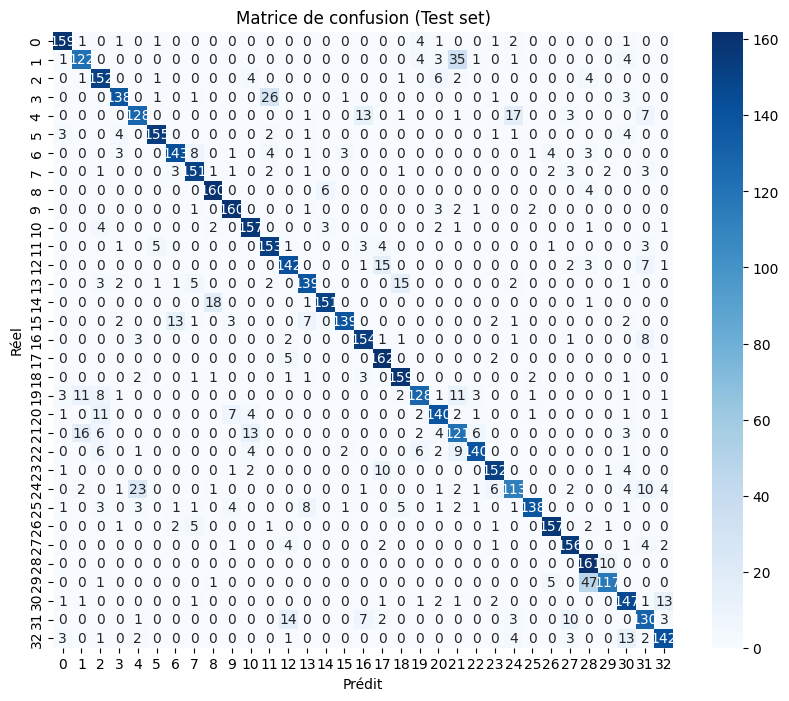

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Test set)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

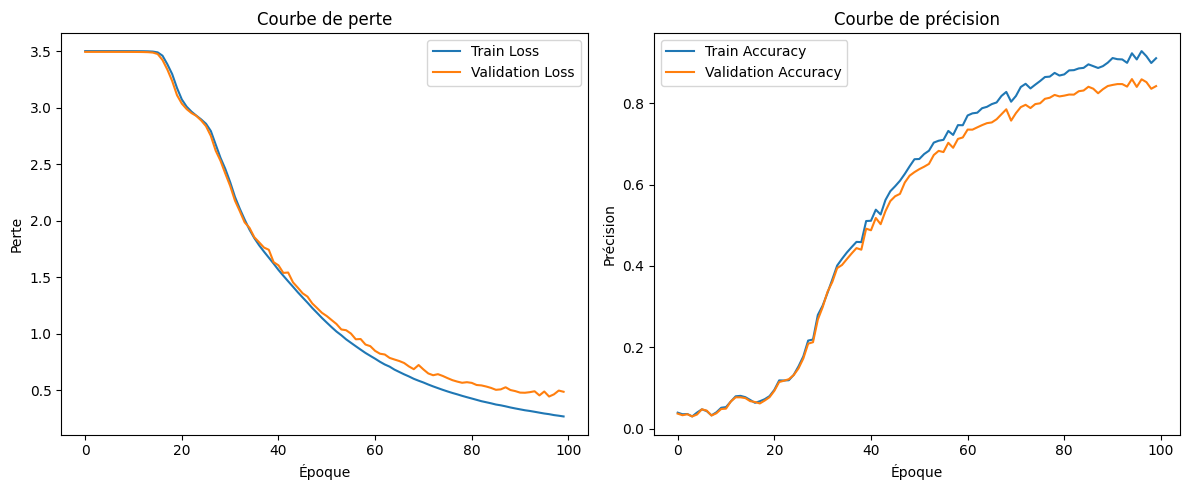

In [ ]:
# Courbes de perte et d’accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Courbe de perte
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte')
ax1.legend()

# Courbe d’accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Courbe de précision')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Précision')
ax2.legend()

plt.tight_layout()
fig.savefig('loss_accuracy_plot.png')
plt.show()
plt.close()
